In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp
import  uncertainties as unc
import numpy as np
import math

from sys import path
path.append('../')
from emc import get_dimuon_df, get_spill_df, emc_analysis, plot_emc, plot_emc_format

%autoreload 2
%aimport emc

### Objectives
1. Create analysis schema and table
2. Get dimuons and spill (proton) data that satisfies specified criteria
3. Specify $x_2$ bin edges and roadset run ranges
4. Calculate EMC ratio for each run range
4. Combine EMC ratio values into a single weighted sum
5. Plot values over E-772 data

Note: set preferences in *emc.cfg* first!

In [5]:
server = 'e906-db3.fnal.gov'
analysis_schema = 'user_dannowitz_qie'
analysis_table = 'kDimuon_qie'
merged_schema_list = ['merged_roadset57_R005_V001',
                      'merged_roadset59_R005_V001',
                      'merged_roadset62_R005_V001',
                      'merged_roadset67_R005_V001',
                      'merged_roadset70_R005_V001']
# If fresh start == True, re-apply all cuts (takes ~10min)
fresh_start = False
#fresh_start = True

In [6]:
# Get valid target dimuons
dimuon_df = get_dimuon_df(server=server, 
                          analysis_schema=analysis_schema, 
                          merged_schema_list=merged_schema_list,
                          analysis_table=analysis_table,
                          fresh_start=fresh_start)                                          

In [7]:
dimuon_df.head()

,dimuonID,runID,spillID,eventID,targetPos,posTrackID,negTrackID,dx,dy,dz,...,isTarget,isDump,QIESum,Intensity_p,weight,dpt,pt1,pt2,target,weight_sq
0,380,8917,303338,5038,6,3248,3249,0.341135,0.306714,-192.348367,...,1,0,1.488180e+11,12009.00,1.093,0.602730,2.348007,2.174108,C,1.194648
1,774,8917,303340,9952,7,6534,6533,0.038868,0.004677,-166.002274,...,1,0,1.503120e+11,7115.28,1.066174,0.875422,2.881120,2.277346,W,1.136727
2,1070,8917,303342,13547,5,8855,8854,-0.189143,-0.026451,-117.398454,...,1,0,1.499180e+11,22723.80,1.241824,0.502025,1.968057,2.448587,Fe,1.542126
3,13922,8918,303430,166004,5,108745,108744,0.200249,0.121474,-248.802101,...,0,0,1.169010e+11,6713.89,1.066082,2.355950,3.104951,0.790083,Fe,1.136531
4,13567,8918,303428,161952,7,106074,106073,-0.119816,-0.039659,-91.814132,...,0,0,1.153540e+11,6390.57,1.059238,0.908070,2.030970,2.889381,W,1.121986


In [8]:
# Get spill data from specified spills
spill_df = get_spill_df(server=server,
                        analysis_schema=analysis_schema,
                        merged_schema_list=merged_schema_list)

In [131]:
dimuon_df.to_csv('dimuon_57_59_62_67_70.tsv', sep='\t')
spill_df.to_csv('spill_57_59_62_67_70.tsv', sep='\t')

In [95]:
run_ranges = [(dimuon_df.min(axis=0)['runID'], dimuon_df.max(axis=0)['runID'])]

In [179]:
print run_ranges

[(10421, 10910)]


In [69]:
# Establish run ranges and x_2 bin edges 
#run_ranges = [(8912, 10420), (11075, 12438), (12525, 15789)]
bin_edges = [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]

In [183]:
emc_df_corrected = emc_analysis(dimuon_df, spill_df, run_ranges, bin_edges, qie_correction=True)
emc_df = emc_analysis(dimuon_df, spill_df, run_ranges, bin_edges, qie_correction=False)

In [184]:
emc_df

,xT,D/H,C/D,Fe/D,Fe/D(iso),W/D,W/D(iso),C/H,Fe/H,W/H,Fe/C,W/C
"(0.08, 0.14]",0.1237346,1.27+/-0.26,0.82+/-0.20,0.82+/-0.19,0.81+/-0.19,0.59+/-0.15,0.56+/-0.15,1.04+/-0.29,1.04+/-0.29,0.74+/-0.22,1.00+/-0.27,0.71+/-0.20
"(0.14, 0.16]",0.1498083,2.0+/-1.0,0.94+/-0.25,1.08+/-0.27,1.04+/-0.26,1.44+/-0.33,1.31+/-0.29,1.9+/-1.2,2.2+/-1.3,2.9+/-1.8,1.14+/-0.30,1.5+/-0.4
"(0.16, 0.18]",0.1699992,1.3+/-0.4,1.22+/-0.27,0.86+/-0.22,0.85+/-0.22,0.83+/-0.20,0.79+/-0.19,1.6+/-0.6,1.1+/-0.4,1.1+/-0.4,0.71+/-0.18,0.68+/-0.16
"(0.18, 0.21]",0.194901,0.83+/-0.14,1.08+/-0.24,0.87+/-0.21,0.89+/-0.21,1.14+/-0.23,1.19+/-0.27,0.90+/-0.21,0.73+/-0.18,0.95+/-0.20,0.81+/-0.21,1.06+/-0.24
"(0.21, 0.25]",0.2288543,0.86+/-0.24,1.3+/-0.4,1.2+/-0.4,1.2+/-0.4,1.2+/-0.4,1.3+/-0.4,1.1+/-0.4,1.0+/-0.4,1.1+/-0.4,0.94+/-0.29,0.98+/-0.28
"(0.25, 0.31]",0.2730513,1.10+/-0.23,0.64+/-0.22,0.84+/-0.24,0.83+/-0.24,1.12+/-0.26,1.10+/-0.28,0.70+/-0.24,0.92+/-0.26,1.22+/-0.29,1.3+/-0.5,1.8+/-0.6
"(0.31, 0.53]",0.3425307,0.9+/-0.4,1.2+/-0.5,1.2+/-0.5,1.2+/-0.5,1.6+/-0.6,1.6+/-0.6,1.1+/-0.6,1.1+/-0.6,1.5+/-0.8,1.0+/-0.4,1.3+/-0.5


In [185]:
emc_df_corrected

,xT,D/H,C/D,Fe/D,Fe/D(iso),W/D,W/D(iso),C/H,Fe/H,W/H,Fe/C,W/C
"(0.08, 0.14]",0.1237346,1.61+/-0.30,0.71+/-0.15,0.75+/-0.17,0.73+/-0.17,0.55+/-0.13,0.51+/-0.13,1.14+/-0.27,1.20+/-0.30,0.89+/-0.23,1.05+/-0.27,0.78+/-0.21
"(0.14, 0.16]",0.1498083,2.3+/-0.9,0.84+/-0.20,0.98+/-0.23,0.94+/-0.22,1.28+/-0.26,1.15+/-0.24,1.9+/-0.9,2.2+/-1.1,2.9+/-1.4,1.16+/-0.30,1.52+/-0.35
"(0.16, 0.18]",0.1699992,1.42+/-0.34,1.10+/-0.22,0.85+/-0.20,0.83+/-0.20,0.77+/-0.18,0.73+/-0.17,1.6+/-0.5,1.2+/-0.4,1.10+/-0.33,0.77+/-0.19,0.70+/-0.16
"(0.18, 0.21]",0.194901,1.07+/-0.18,0.94+/-0.19,0.85+/-0.19,0.84+/-0.20,0.96+/-0.19,0.95+/-0.20,1.01+/-0.21,0.91+/-0.21,1.03+/-0.20,0.90+/-0.23,1.02+/-0.23
"(0.21, 0.25]",0.2288543,1.05+/-0.25,1.16+/-0.28,1.03+/-0.27,1.03+/-0.28,1.12+/-0.28,1.11+/-0.29,1.2+/-0.4,1.08+/-0.34,1.18+/-0.35,0.89+/-0.24,0.97+/-0.24
"(0.25, 0.31]",0.2730513,1.42+/-0.30,0.62+/-0.18,0.75+/-0.21,0.74+/-0.21,1.06+/-0.25,1.00+/-0.25,0.88+/-0.26,1.07+/-0.29,1.5+/-0.4,1.2+/-0.4,1.7+/-0.5
"(0.31, 0.53]",0.3425307,1.4+/-0.6,1.0+/-0.4,1.0+/-0.4,0.9+/-0.4,1.2+/-0.4,1.2+/-0.4,1.3+/-0.6,1.3+/-0.7,1.7+/-0.8,1.0+/-0.4,1.3+/-0.5


In [74]:
bin_centers = emc_df['xT'].values
lower_val = np.subtract(bin_centers,bin_edges[:-1])
upper_val = np.subtract(bin_edges[1:], bin_centers)
asymmetric_bars = [lower_val, upper_val]

In [82]:
# Store the E772 results
e772_dict = {}
# DY Ratio for C/D vrs Xtgt - E772
# --------------------------------
e772_dict['C/D'] = {}
e772_dict['C/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['C/D']['ratio'] = unp.uarray([0.981, 0.974, 1.013, 1.011, 0.979, 1.049, 1.117, 1.151, 1.044],
                                        [0.017, 0.014, 0.016, 0.020, 0.027, 0.044, 0.074, 0.110, 0.202])

# DY Ratio for Fe/D vrs Xtgt - E772
# --------------------------------
e772_dict['Fe/D'] = {}
e772_dict['Fe/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.219, 0.271]
e772_dict['Fe/D']['ratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                         [0.014, 0.011, 0.012, 0.014, 0.018, 0.027, 0.037, 0.050, 0.088])

# DY Ratio for W/D vrs Xtgt - E772
# --------------------------------
e772_dict['W/D'] = {}
e772_dict['W/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['W/D']['ratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                        [0.016, 0.013, 0.016, 0.020, 0.026, 0.043, 0.067, 0.099, 0.192])

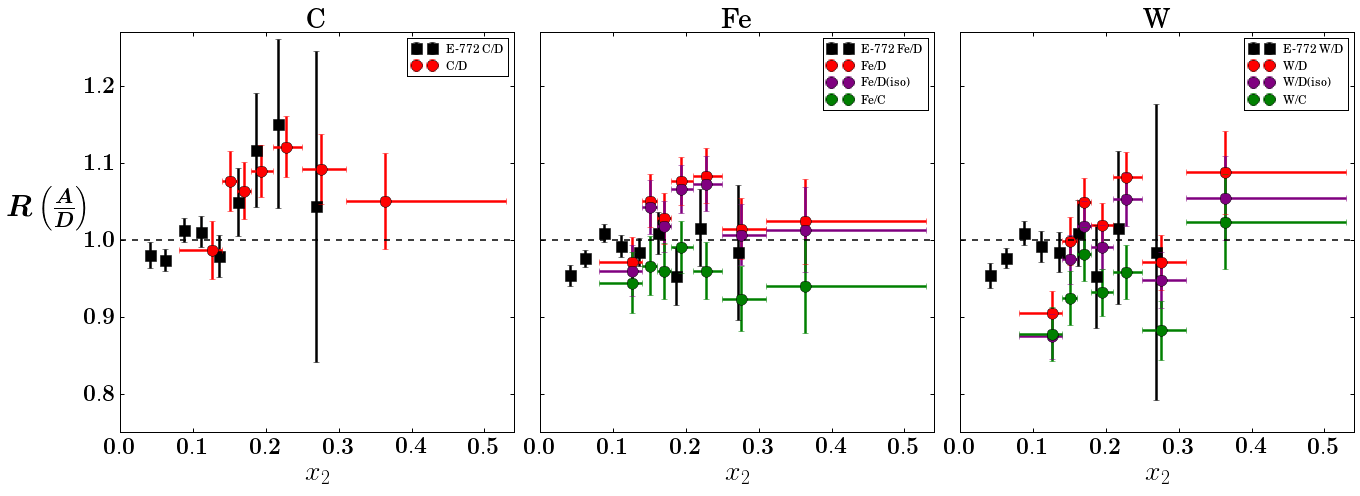

In [76]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(19,7))

ax1.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$',
               fontsize=30, rotation=0, labelpad=35)
plot_emc(e772_dict['C/D']['bin_centers'],
         e772_dict['C/D']['uratio'],
         label='E-772 C/D',
         fmt='s',
         color='black',
         ax=ax1)
plot_emc(bin_centers,
         emc_df['C/D'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='red',
         label='C/D',
         ax=ax1)
plot_emc_format(ax1, 'C')

plot_emc(e772_dict['Fe/D']['bin_centers'],
         e772_dict['Fe/D']['uratio'],
         label='E-772 Fe/D',
         fmt='s',
         color='black',
         ax=ax2)
plot_emc(bin_centers,
         emc_df['Fe/D'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='red',
         label='Fe/D',
         ax=ax2)
plot_emc(bin_centers,
         emc_df['Fe/D(iso)'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='purple',
         label='Fe/D(iso)',
         ax=ax2)
plot_emc(bin_centers,
         emc_df['Fe/C'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='green',
         label='Fe/C',
         ax=ax2)
plot_emc_format(ax2, 'Fe')

plot_emc(e772_dict['W/D']['bin_centers'],
         e772_dict['W/D']['uratio'],
         label='E-772 W/D',
         fmt='s',
         color='black',
         ax=ax3)
plot_emc(bin_centers,
         emc_df['W/D'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='red',
         label='W/D',
         ax=ax3)
plot_emc(bin_centers,
         emc_df['W/D(iso)'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='purple',
         label='W/D(iso)',
         ax=ax3)
plot_emc(bin_centers,
         emc_df['W/C'].values,
         xerr=asymmetric_bars,
         fmt='o',
         color='green',
         label='W/C',
         ax=ax3)
plot_emc_format(ax3, 'W')

# Set format and location of tickmarks
xtick_locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
ytick_locs = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plt.xticks(xtick_locs, [r"$\mathbf{%.1f}$" % x for x in xtick_locs]) 
plt.yticks(ytick_locs, [r"$\mathbf{%.1f}$" % x for x in ytick_locs]) 

# Set x and y limits
lims = (0, 0.54, 0.75, 1.27)
ax1.axis(lims); ax2.axis(lims); ax3.axis(lims);

plt.tight_layout()
plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.show()

In [72]:
target_df.ix['LH2'].Scale

2.1659474249265598e+24

In [20]:
qie_systematic = {'C/D': 0.0396630986042,
                  'Fe/D': 0.0606710075894,
                  'W/D': 0.0396895838982}
total_systematic = {}
for target in sys_diff:
     total_systematic[target] = np.sqrt(np.square(sys_diff[target]) + qie_systematic[target]**2) 

In [21]:
zipset = zip(bin_edges[:-1],bin_edges[1:])   
rangeset = []
fillvalues = {}

for ratio in ('C/D', 'Fe/D', 'W/D'):
    fillvalues[ratio] = []
    for i in range(len(total_systematic[ratio])):
        fillvalues[ratio].append(total_systematic[ratio][i])
        fillvalues[ratio].append(total_systematic[ratio][i])
    fillvalues[ratio] = np.array(fillvalues[ratio])

for pair in zipset:
    rangeset.append(pair[0])
    rangeset.append(pair[1])
    
rangeset = np.array(rangeset)
bottom = 0.77*np.ones_like(rangeset)

{'W/D': array([ 0.04035796,  0.04035796,  0.04040575,  0.04040575,  0.04043381,
        0.04043381,  0.04041889,  0.04041889,  0.04042744,  0.04042744,
        0.04036565,  0.04036565,  0.0405603 ,  0.0405603 ]), 'C/D': array([ 0.04018309,  0.04018309,  0.04025956,  0.04025956,  0.04023195,
        0.04023195,  0.04032557,  0.04032557,  0.0402735 ,  0.0402735 ,
        0.0402362 ,  0.0402362 ,  0.0404907 ,  0.0404907 ]), 'Fe/D': array([ 0.06106183,  0.06106183,  0.06114859,  0.06114859,  0.06107235,
        0.06107235,  0.06118214,  0.06118214,  0.06107895,  0.06107895,
        0.06108974,  0.06108974,  0.06109465,  0.06109465])}
[ 0.08  0.14  0.14  0.16  0.16  0.18  0.18  0.21  0.21  0.25  0.25  0.31
  0.31  0.53]
[ 0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77
  0.77  0.77]


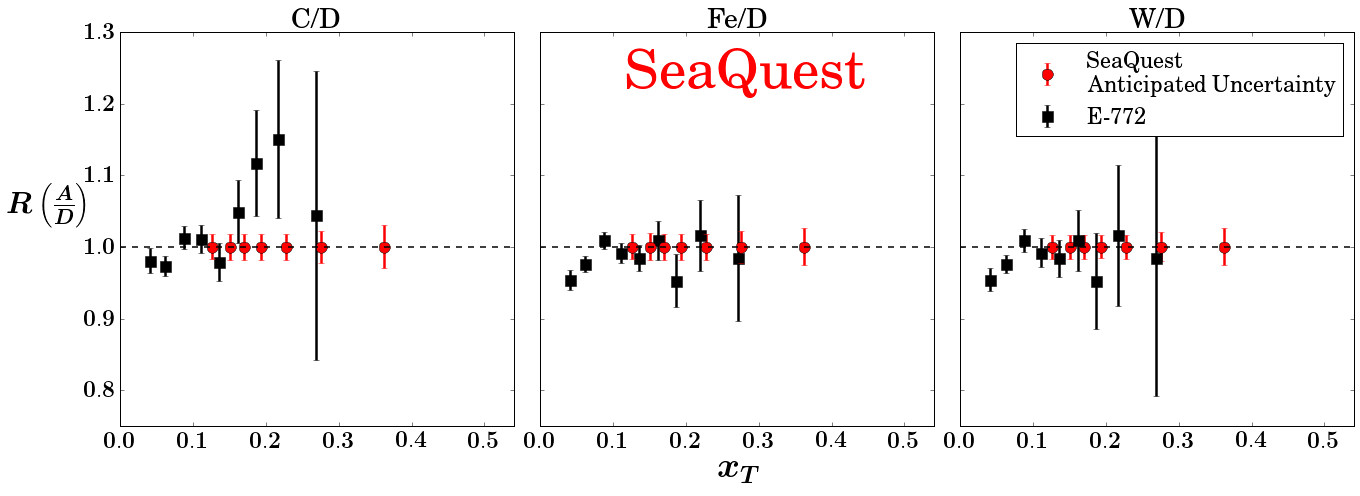

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(19,7))

ax1.set_title('C/D', fontsize=28)
ax1.errorbar(e772_dict['C/D']['bin_centers'], unp.nominal_values(e772_dict['C/D']['uratio']),
            unp.std_devs(e772_dict['C/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 C/D') 
ax1.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['C/D'].values)),
             yerr=np.divide(unp.std_devs(emc_df['C/D'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest')
ax1.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax1.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$', fontsize=30, rotation=0, labelpad=35)
plt.setp(ax1.get_xticklabels(), fontsize=23)
plt.setp(ax1.get_yticklabels(), fontsize=23)

ax2.set_title('Fe/D', fontsize=28)
ax2.errorbar(e772_dict['Fe/D']['bin_centers'], unp.nominal_values(e772_dict['Fe/D']['uratio']),
            unp.std_devs(e772_dict['Fe/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 Fe/D') 
ax2.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['Fe/D(iso)'].values)),
             yerr=np.divide(unp.std_devs(emc_df['Fe/D(iso)'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest')
ax2.set_xlabel(r'$\boldsymbol{x_T}$', fontsize=35)
ax2.axhline(y=1, c='black', ls='--', linewidth=1.5)
plt.setp(ax2.get_xticklabels(), fontsize=23)

ax3.set_title('W/D', fontsize=28)
ax3.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['W/D(iso)'].values)),
             yerr=np.divide(unp.std_devs(emc_df['W/D(iso)'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest\nAnticipated Uncertainty')
ax3.errorbar(e772_dict['W/D']['bin_centers'], unp.nominal_values(e772_dict['W/D']['uratio']),
            unp.std_devs(e772_dict['W/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772') 
ax3.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax3.legend(loc='best', fontsize=22, numpoints=1)
plt.setp(ax3.get_xticklabels(), fontsize=23)

xtick_locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
ytick_locs = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plt.xticks(xtick_locs, [r"$\mathbf{%.1f}$" % x for x in xtick_locs]) 
plt.yticks(ytick_locs, [r"$\mathbf{%.1f}$" % x for x in ytick_locs]) 

f.text(0.95, 0.05, 'SeaQuest',
         fontsize=55, color='red',
         position=(0.46, 0.82))

ax3.axis((0, 0.54, 0.75, 1.3))

plt.tight_layout()
plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.setp([a.get_xticklines() for a in f.axes[:]], lw=20)
plt.show()